#### Import libraries

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score, accuracy_score
import seaborn as sns

In [23]:
from sklearn.metrics import classification_report

In [3]:
import pandas as pd

#### Transformation of images

In [4]:
data_transforms = transforms.Compose([
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.3),  
    transforms.RandomRotation(15), 
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1), 
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.1),
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [5]:
test_val_transforms = transforms.Compose([
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_dataset = datasets.ImageFolder(root='data/split_dataset/train', transform=data_transforms)
val_dataset = datasets.ImageFolder(root='data/split_dataset/val', transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root='data/split_dataset/test', transform=test_val_transforms)

print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the validation dataset: {len(val_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")

Number of images in the training dataset: 4803
Number of images in the validation dataset: 1029
Number of images in the test dataset: 1030


In [7]:
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Model with different parameters

In [16]:
class CNN(nn.Module):
    def __init__(self, conv_layers=[(3, 32), (32, 64)], c1_neurons=128, use_dropout=False, dropout_rate=0.5):
        super(CNN, self).__init__()
        # List to store convolutional layers:
        self.conv_layers = nn.ModuleList()

        in_channels = 3
        # conv layers based on given params
        for layer in conv_layers:
            out_channels = layer[1] 
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            in_channels = out_channels 
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.dummy_input = torch.zeros(1, 3, 224, 224)
        self.flattened_size = self._get_conv_output(self.dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, c1_neurons) 
        # len(train_dataset.classes) = 11
        self.fc2 = nn.Linear(c1_neurons, len(train_dataset.classes))  

        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):

        for conv_layer in self.conv_layers:
            x = F.relu(conv_layer(x))
            x = self.pool(x)

        # Flatten the tensor
        x = x.flatten(start_dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        
        return x

    def _get_conv_output(self, shape):
        """Helper function to calculate the flattened size after convolution layers"""
        with torch.no_grad():
            x = shape
            for conv_layer in self.conv_layers:
                x = F.relu(conv_layer(x))
                x = self.pool(x)
            return int(np.prod(x.size()))

Train model function:

In [19]:
def train_model(model, train_loader, val_loader, batch_size, criterion, optimizer, learning_rate, num_epochs, device):

    print("===========================================================================================================")
    print(f"Training with the following configuration:\n"
          f"Learning Rate: {learning_rate}\n"
          f"Batch Size: {batch_size}\n"
          f"Optimizer: {optimizer.__class__.__name__}\n"
          f"Loss Function: {criterion.__class__.__name__}\n"
          f"Number of Epochs: {num_epochs}\n")
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        # calculate model perfomance
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total    
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
    
        # calculate model perfomance
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
    
        # save model perfomance
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
     #    if scheduler:
     #        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

Info to compare model prefomance on different params.
I would compare by train_accuracy, val_accuracy, train_loss, val_loss, val_losses on each epoch

In [39]:
models_perfomance = []

Trying different params to find the best combination:

In [40]:
param_combinations = [
    {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': torch.optim.Adam, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 4},
    {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': torch.optim.SGD, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 6},
    {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': torch.optim.Adam, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 4},
    {'learning_rate': 0.001, 'batch_size': 128, 'optimizer': torch.optim.Adam, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 4},
    {'learning_rate': 0.01, 'batch_size': 64, 'optimizer': torch.optim.Adam, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 4},
    {'learning_rate': 0.01, 'batch_size': 64, 'optimizer': torch.optim.SGD, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 5},
    {'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': torch.optim.Adam, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 6},
    {'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': torch.optim.SGD, 'criterion': torch.nn.CrossEntropyLoss, 'num_epochs': 7},
]

As training time is long on my data and models, I use 5 epochs to make a lite analysis

In [41]:
def train_models(models_perfomance, param_combinations, model_class):
    for params in param_combinations:
        model = model_class()
        
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        criterion = params['criterion']()
        optimizer = params['optimizer'](model.parameters(), lr=learning_rate) 
        num_epochs = params['num_epochs']

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, batch_size, criterion, optimizer, params['learning_rate'], num_epochs, device
        )
        models_perfomance.append({
            'params': params,
            'train_accuracy': train_accuracies,
            'val_accuracy': val_accuracies,
            'train_loss': train_losses,
            'val_loss': val_losses,
        })
    return models_perfomance       

In [42]:
models_perfomance1 = train_models(models_perfomance, param_combinations, CNN)

Training with the following configuration:
Learning Rate: 0.001
Batch Size: 64
Optimizer: Adam
Loss Function: CrossEntropyLoss
Number of Epochs: 4

Epoch 1/4, Train Loss: 2.0113, Train Acc: 41.52%, Val Loss: 1.3541, Val Acc: 55.59%
Epoch 2/4, Train Loss: 1.3264, Train Acc: 55.65%, Val Loss: 1.1724, Val Acc: 62.10%
Epoch 3/4, Train Loss: 1.1593, Train Acc: 60.61%, Val Loss: 1.0492, Val Acc: 66.28%
Epoch 4/4, Train Loss: 1.0903, Train Acc: 63.34%, Val Loss: 1.0172, Val Acc: 64.72%
Training with the following configuration:
Learning Rate: 0.001
Batch Size: 64
Optimizer: SGD
Loss Function: CrossEntropyLoss
Number of Epochs: 6

Epoch 1/6, Train Loss: 2.2887, Train Acc: 19.13%, Val Loss: 2.1904, Val Acc: 27.60%
Epoch 2/6, Train Loss: 2.1335, Train Acc: 31.25%, Val Loss: 2.0065, Val Acc: 37.71%
Epoch 3/6, Train Loss: 1.9962, Train Acc: 37.43%, Val Loss: 1.8502, Val Acc: 47.52%
Epoch 4/6, Train Loss: 1.8926, Train Acc: 42.14%, Val Loss: 1.7536, Val Acc: 49.95%
Epoch 5/6, Train Loss: 1.7950, Tr

Now we have training results for 8 different parameters settings. Lets see them on graphs.

To save training perfomance of models:

In [47]:
#models_perfomance1_df = pd.DataFrame(models_perfomance1)
#models_perfomance1_df.to_csv('models_performance1.csv', index=False)

In [56]:
#models_perfomance1

In [77]:
def plot_metric_results(models_performance, metric):
    plt.figure(figsize=(12, 4))

    for entry in models_performance:
        params = entry['params']
        metric_values = entry[metric]
        num_epochs = len(metric_values)
        epochs = range(1, num_epochs + 1)

        label = (f"LR: {params['learning_rate']}, "
                 f"BS: {params['batch_size']}, "
                 f"Opt: {params['optimizer'].__name__}")

        plt.plot(epochs, metric_values, label=label)
        
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'{metric}s for different parameter combinations')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

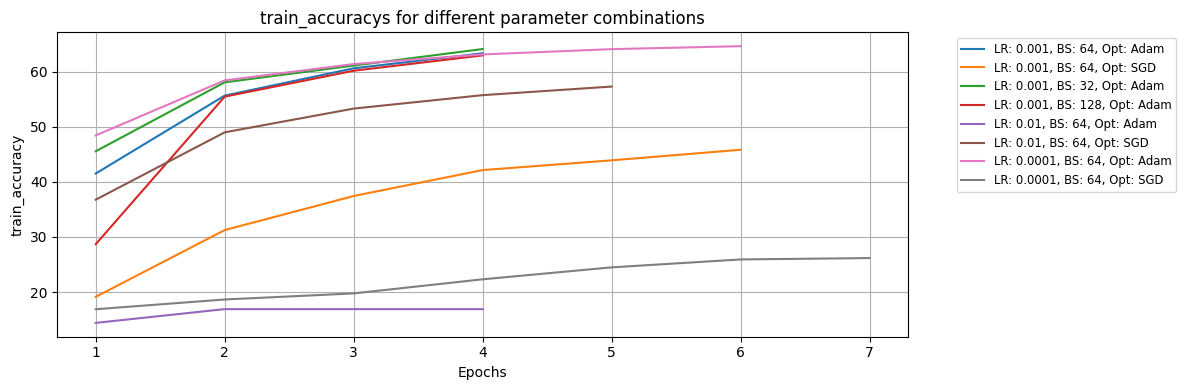

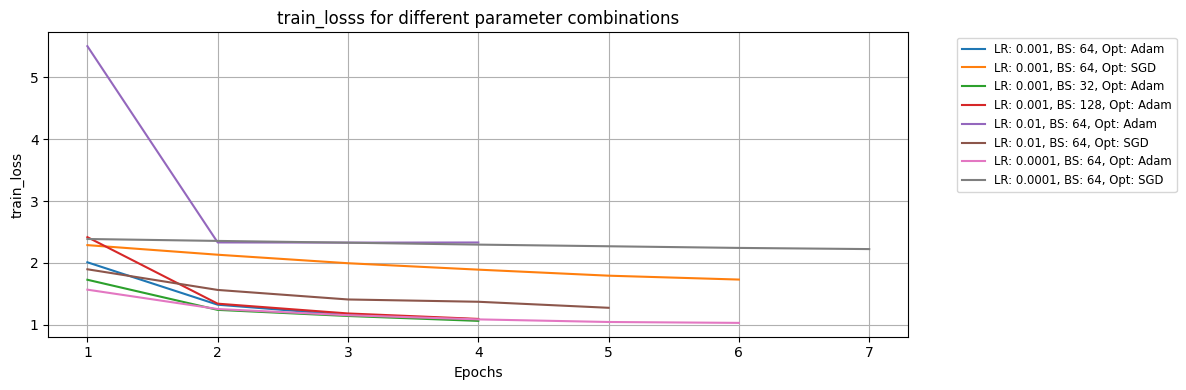

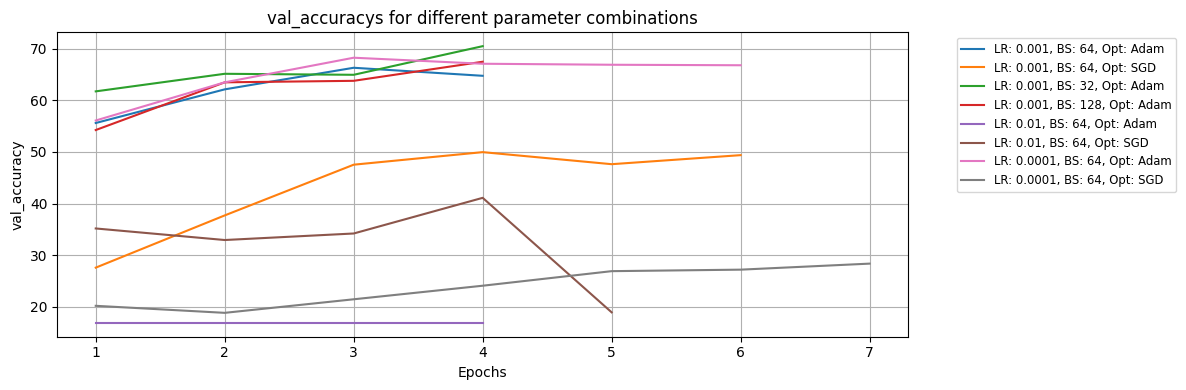

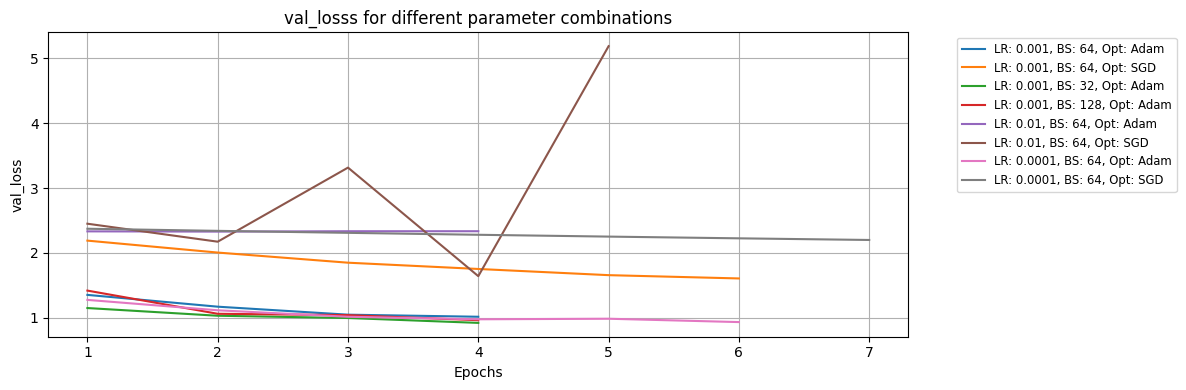

In [78]:
metrics = ["train_accuracy", "train_loss", "val_accuracy","val_loss"]
for metric in metrics:
    plot_metric_results(models_perfomance1, metric)

Models with SGD optimizer show worse results so we could defenitely stick to Adam optimizer. Also learning rate 0.01 is not suitable. 
learning_rate 0.0001 and batch sizes 32 and 64 are pretty good but as for now i didn't see a good improvement compared to out base model. 

Also we could try to change number of conv layers, neurons and weather to use dropouts

#### Model with different architectures

In [67]:
def train_models2(models_performance, architecture, model_class):
    for arch_params in architecture:
        model = model_class(**arch_params) 
        
        learning_rate = 0.001  
        batch_size = 64  
        criterion = nn.CrossEntropyLoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        num_epochs = 10  
    
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        print()
        print(f"Training model with architecture: {arch_params}")
        
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, batch_size, criterion, optimizer, learning_rate, num_epochs, device
        )

        models_performance.append({
            'architecture': arch_params,
            'train_accuracy': train_accuracies,
            'val_accuracy': val_accuracies,
            'train_loss': train_losses,
            'val_loss': val_losses,
        })
    
    return models_performance

In [68]:
architecture = [
    {'conv_layers': [(3, 32), (32, 64)], 'c1_neurons': 64},  
    {'conv_layers': [(3, 32), (32, 64)], 'c1_neurons': 256},  
    {'conv_layers': [(3, 32), (32, 64), (64, 128)], 'c1_neurons': 128}  
]

In [69]:
models_performance = []
models_performance2 = train_models2(models_performance, architecture, CNN)


Training model with architecture: {'conv_layers': [(3, 32), (32, 64)], 'c1_neurons': 64}
Training with the following configuration:
Learning Rate: 0.001
Batch Size: 64
Optimizer: Adam
Loss Function: CrossEntropyLoss
Number of Epochs: 10

Epoch 1/10, Train Loss: 2.0307, Train Acc: 38.77%, Val Loss: 1.3660, Val Acc: 56.95%
Epoch 2/10, Train Loss: 1.3743, Train Acc: 54.94%, Val Loss: 1.1256, Val Acc: 61.81%
Epoch 3/10, Train Loss: 1.2533, Train Acc: 58.51%, Val Loss: 1.0930, Val Acc: 62.00%
Epoch 4/10, Train Loss: 1.2297, Train Acc: 58.67%, Val Loss: 1.0806, Val Acc: 63.27%
Epoch 5/10, Train Loss: 1.1273, Train Acc: 61.40%, Val Loss: 1.0303, Val Acc: 64.82%
Epoch 6/10, Train Loss: 1.1082, Train Acc: 61.96%, Val Loss: 1.0329, Val Acc: 64.82%
Epoch 7/10, Train Loss: 1.0686, Train Acc: 63.98%, Val Loss: 0.9742, Val Acc: 67.06%
Epoch 8/10, Train Loss: 1.0542, Train Acc: 63.71%, Val Loss: 0.9891, Val Acc: 66.47%
Epoch 9/10, Train Loss: 1.0318, Train Acc: 64.81%, Val Loss: 0.9554, Val Acc: 67.

To save models training perfomances:

In [76]:
#models_perfomance2_df = pd.DataFrame(models_performance2)
#models_perfomance2_df.to_csv('models_performance2.csv', index=False)

In [ ]:
#models_perfomance2

In [83]:
def plot_arch_results(models_perfomance, metric):
    plt.figure(figsize=(12, 4))

    for entry in models_performance:
        params = entry['architecture']
        arch_values = entry[metric]
        num_epochs = len(arch_values)
        epochs = range(1, num_epochs + 1)

        label = (f"Conv_l: {params['conv_layers']}, "
                 f"Neur: {params['c1_neurons']}")

        plt.plot(epochs, arch_values, label=label)
        
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'{metric}s for different model architectures')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

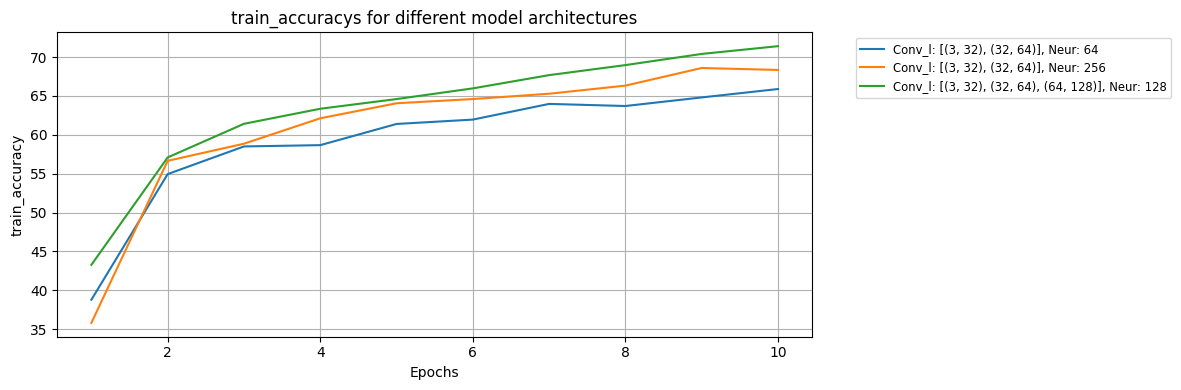

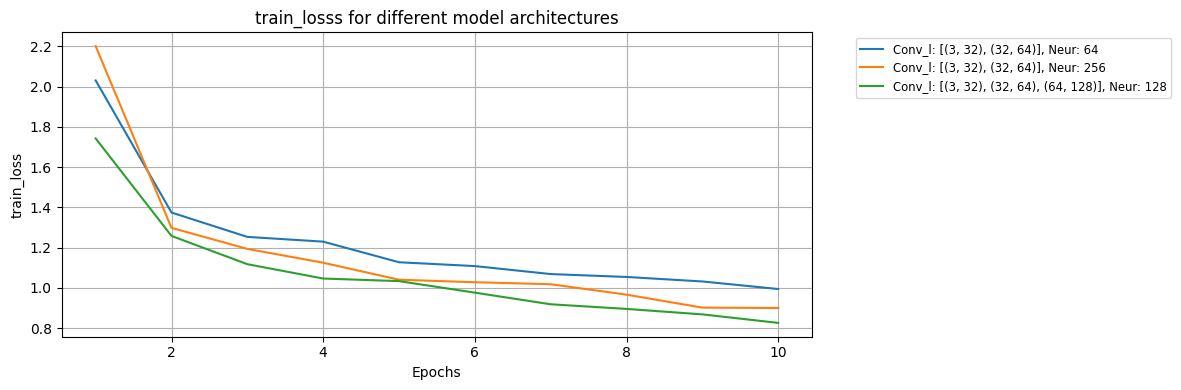

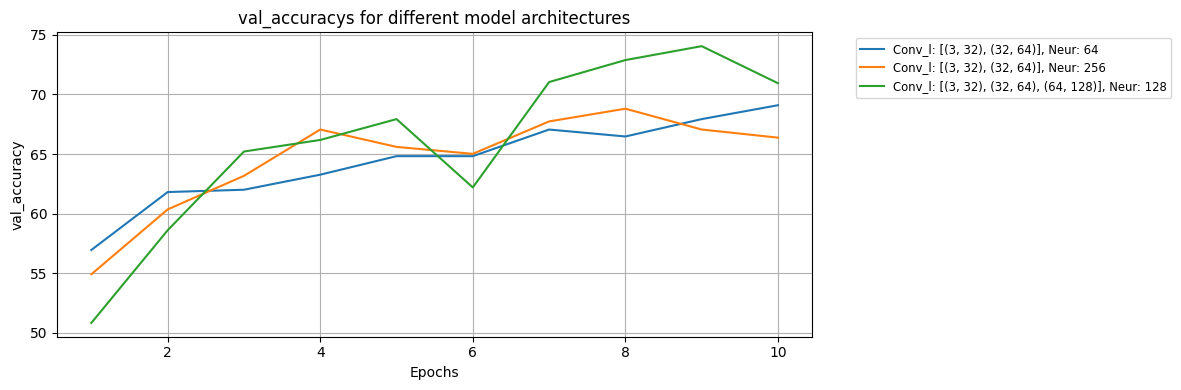

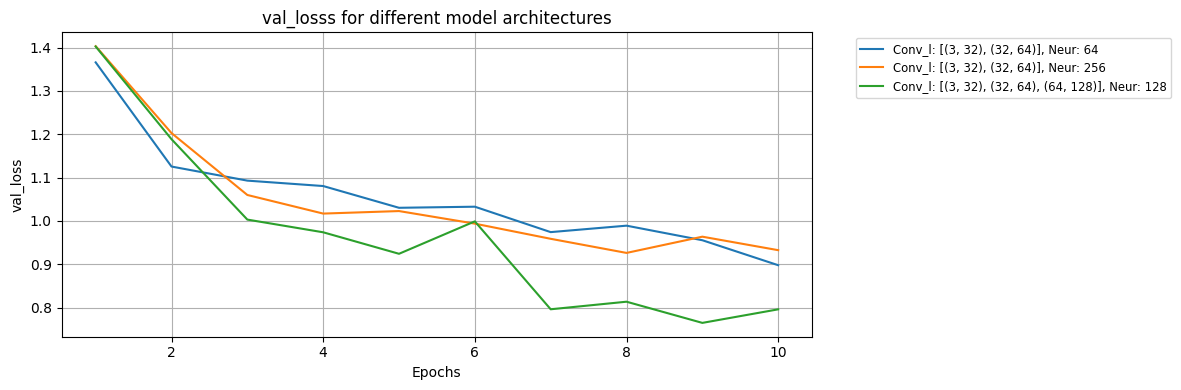

In [84]:
metrics = ["train_accuracy", "train_loss", "val_accuracy","val_loss"]
for metric in metrics:
    plot_arch_results(models_performance2, metric)

Model with 3 convolutional layer has interesting results. I think we could try it with dropout on bigger number of epochs.

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [20]:
model2 =  CNN(conv_layers=[(3, 32), (32, 64), (64, 128)], c1_neurons=128, use_dropout=True, dropout_rate=0.3)

learning_rate = 0.001  
batch_size = 64  
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
num_epochs = 16

print("Training model with architecture: {'conv_layers': [(3, 32), (32, 64), (64, 128)], c1_neurons=128, dropout_rate=0.3}")
train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train_model(
    model2, train_loader, val_loader, batch_size, criterion, optimizer, learning_rate, num_epochs, device
)

Training model with architecture: {'conv_layers': [(3, 32), (32, 64), (64, 128)], c1_neurons=128, dropout_rate=0.3}
Training with the following configuration:
Learning Rate: 0.001
Batch Size: 64
Optimizer: Adam
Loss Function: CrossEntropyLoss
Number of Epochs: 16

Epoch 1/16, Train Loss: 1.8071, Train Acc: 40.97%, Val Loss: 1.1615, Val Acc: 61.32%
Epoch 2/16, Train Loss: 1.3339, Train Acc: 55.05%, Val Loss: 1.0501, Val Acc: 63.56%
Epoch 3/16, Train Loss: 1.2010, Train Acc: 58.34%, Val Loss: 1.0866, Val Acc: 61.13%
Epoch 4/16, Train Loss: 1.1848, Train Acc: 61.00%, Val Loss: 1.0001, Val Acc: 64.43%
Epoch 5/16, Train Loss: 1.1189, Train Acc: 62.50%, Val Loss: 0.9492, Val Acc: 66.96%
Epoch 6/16, Train Loss: 1.1095, Train Acc: 62.09%, Val Loss: 0.9439, Val Acc: 67.06%
Epoch 7/16, Train Loss: 1.0450, Train Acc: 63.73%, Val Loss: 0.8687, Val Acc: 70.94%
Epoch 8/16, Train Loss: 1.0193, Train Acc: 64.63%, Val Loss: 0.8571, Val Acc: 69.97%
Epoch 9/16, Train Loss: 1.0093, Train Acc: 65.08%, Val 

#### Model comparison

I didn't see a good imrovement to my base model despite trying different params and architecture styles.
Model with conv layers 3 has a better result on 15 epoch but wether it is better than my base model i can't tell for now.

In [21]:
# torch.save(model2.state_dict(), 'models\\model2\\model2_state_dict.pth')
# torch.save({
#         'train_losses': train_losses2,
#         'val_losses': val_losses2,
#         'train_accuracies': train_accuracies2,
#         'val_accuracies': val_accuracies2
#     },  'models\\model2\\training_history2.pth')

In [19]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # First convolutional layer: 3 input channel (RGB), 32 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) 
        # Second convolutional layer: 32 input channel, 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) 
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128) 
        
        # len(train_dataset.classes) = 11
        self.fc2 = nn.Linear(128, len(train_dataset.classes))  

    def forward(self, x):
        # conv1 + relu + pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # conv2 + relu + pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the tensor
        x = x.reshape(x.shape[0], -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [20]:
#model1 = CNN2()

In [21]:
#model1.load_state_dict(torch.load('models\\model1\\model_state_dict.pth'))
#model1.eval()

CNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)

In [24]:
model2 = CNN(conv_layers=[(3, 32), (32, 64), (64, 128)], c1_neurons=128, use_dropout=True, dropout_rate=0.3)

In [25]:
model2.load_state_dict(torch.load('models\\model2\\model2_state_dict.pth'))
model2.eval()

CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Here are a simple comparison of base model and a new selected model using test data:

In [27]:
model1.eval
model2.eval()

predictions1 = []
true_labels1 = []

predictions2 = []
true_labels2 = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch 
        outputs = model1(inputs) 
        
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        predictions1.extend(preds)
        true_labels1.extend(labels.cpu().numpy())

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch 
        outputs = model2(inputs) 
        
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        predictions2.extend(preds)
        true_labels2.extend(labels.cpu().numpy())


print(classification_report(true_labels1, predictions1))
print(classification_report(true_labels2, predictions2))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       105
           1       0.91      0.83      0.87       128
           2       0.53      0.51      0.52        71
           3       0.58      0.62      0.60        96
           4       0.70      0.64      0.67        89
           5       0.81      0.86      0.83        56
           6       0.58      0.77      0.66        79
           7       0.79      0.66      0.72        35
           8       0.76      0.79      0.77       174
           9       0.90      0.88      0.89       104
          10       0.60      0.63      0.62        93

    accuracy                           0.73      1030
   macro avg       0.73      0.72      0.72      1030
weighted avg       0.74      0.73      0.73      1030

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       105
           1       0.92      0.77      0.84       128
           2       0.47 